# Importar librerias

In [1]:
%load_ext autoreload
%autoreload 2

import dgl
import torch
from torch.optim import Adam
import itertools
import torch.nn.functional as F
# Sampling
import tqdm

from modules.gnn import GNN
from modules.predictors import DotPredictor, MLPPredictor
from modules.models import  ModelGraphSAGE, GraphSAGE, GCN, ModelGCN, ModelSAGESample #ModelGraphSAGE,GraphSAGE, GCN,ModelSAGESample,SAGE, ModelGCN
from utils import plot_roc_curve, plot_training, calculate_metrics

import pandas as pd


/home/valentina/Desktop/GIT/TrabajoTesis/env310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Versión de DGL:", dgl.__version__)
print("Versión de PyTorch:", torch.__version__)

TOR_LABELS_DICT = {'P2P':0, 'C2P': 1,'P2C': 2}

Versión de DGL: 2.4.0+cu121
Versión de PyTorch: 2.3.0+cu121


# Diccionario de casos de prueba

In [8]:
cases = {
    "CASO_1": {
        "data_path": "data/DGL_Graph/MultiDiGraph_AllFeatures/",
        "features_type": "AllFeatures",
        "size_train": 0.8,
        "model": GCN,
        "predictor": MLPPredictor,
        'sampling': None,
        'description': 'GCN con predictor de MLP'
    },
    # "CASO_2": {
    #     "data_path": "data/DGL_Graph/MultiDiGraph_AllFeatures/",
    #     "features_type": "AllFeatures",
    #     "size_train": 0.8,
    #     "model": GraphSAGE,
    #     "predictor": MLPPredictor,
    #     "description": "GraphSAGE con predictor de MLP"
    # },
    # "CASO_3": {
    #     "data_path": "data/DGL_Graph/MultiDiGraph_DegreeFeatures/",
    #     "features_type": "MultiDiGraph_DegreeFeatures",
    #     "size_train": 0.8,
    #     "model": ModelGCN,
    #     "predictor": MLPPredictor,
    #     "description": "GraphSAGE con predictor de MLP"
    # },
    # "CASO_4": { #TODO: Revisar
    #     "data_path": "data/DGL_Graph/MultiDiGraph_DegreeFeatures/", # data/DGL_Graph/MultiDiGraph_DegreeFeatures/
    #     "features_type": "MultiDiGraph_DegreeFeatures",
    #     "size_train": 0.8,
    #     "model": ModelGraphSAGE,
    #     "predictor": MLPPredictor,
    #     "description": "GraphSAGE con predictor de MLP con Random Neighbour Sampling"
    # },

    # "CASO_7": {
    #     "data_path": "data/DGL_Graph/DiGraph_AllFeatures/",
    #     "features_type": "DiGraph_DegreeFeatures",
    #     "size_train": 0.8,
    #     "model": ModelSAGESample,
    #     "predictor": MLPPredictor,
    #     "sampling": dgl.dataloading.NeighborSampler,
    #     "description": "Sampling con neighbour node sampling y batch normalizationGraphSAGE con predictor de Dot"
    # },

    # "CASO_5": {
    #     "data_path": "data/DGL_Graph/DiGraph_AllFeatures/",
    #     "features_type": "DiGraph_DegreeFeatures",
    #     "size_train": 0.8,
    #     "model": ModelSAGESample,
    #     "predictor": MLPPredictor,
    #     "sampling": dgl.dataloading.ClusterGCNSampler,
    #     "description": "Sampling con neighbour node sampling y batch normalizationGraphSAGE con predictor de Dot"
    # },

}

# Funciones Auxiliares

In [11]:

def load_and_prepare_data(data_path, size_train):
    gnn = GNN(debug=True)
    gnn.load_dataset(data_path, force_reload=True)
    gnn.split_dataset(size_train)
    # gnn.split_dtaset_v2()
    gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float() #FIXME:
    return gnn


def initialize_model(gnn, model, predictor, lr ,h_feats_model, out_feat_model , out_feat_predictor = None):
    in_feats = gnn.dgl_graph.ndata['feat'].shape[1]

    model = model(in_feats, h_feats_model, out_feat_model)
    pred = predictor( out_feat_model, out_feat_predictor)
    
    optimizer = Adam(itertools.chain(model.parameters(), pred.parameters()), lr=lr)
    return model, pred, optimizer

def train_model(case, gnn, model, pred, optimizer, num_epochs=100):
    train_mask = gnn.train_mask
    val_edges_mask = gnn.val_mask
    labels = gnn.dgl_graph.edata["Relationship"].long()

    model_complexity = []
    train_error_per_epoch = []
    val_error_per_epoch = []
    train_acc_per_epoch = []
    val_acc_per_epoch = []

    for epoch in range(num_epochs):
        # forward
        h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
        print('h:', h)
        print('h.shape:', h.shape)
        print('type:', type(h))
        logits = pred(gnn.dgl_graph, h)
        print('logits:', logits)
        print('logits.shape:', logits.shape)
        print('type:', type(logits))
        scores = logits.argmax(1)
        print('scores:', scores)
        print('scores.shape:', scores.shape)
        print('type:', type(scores))

        print('labels:', labels)
        print('labels.shape:', labels.shape)
        print('type:', type(labels))
        print('Valores únicos en labels:', labels.unique())
        # Calculo pérdida
        train_loss = F.cross_entropy(logits[train_mask], labels[train_mask])
        val_loss = F.cross_entropy(logits[val_edges_mask], labels[val_edges_mask])

        # Calculo accuracy
        train_acc = (scores[train_mask] == labels[train_mask]).float().mean().item()
        val_acc = (scores[val_edges_mask] == labels[val_edges_mask]).float().mean().item()

        # Guardar valores
        train_error_per_epoch.append(train_loss.item())
        val_error_per_epoch.append(val_loss.item())
        train_acc_per_epoch.append(train_acc)
        val_acc_per_epoch.append(val_acc)
        model_complexity.append(epoch + 1)

        # backward
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch % 20 == 0:
            print('In epoch {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # Guardar los valores en un archivo CSV
    df = pd.DataFrame({
        'epoch': model_complexity,
        'train_error': train_error_per_epoch,
        'val_error': val_error_per_epoch,
        'acc_train': train_acc_per_epoch,
        'acc_val': val_acc_per_epoch
    })
    df.to_csv(f'results/multiclass_classification/training_results_{case}.csv', index=False)

    return logits, train_error_per_epoch, val_error_per_epoch, train_acc_per_epoch, val_acc_per_epoch, model_complexity, scores

def train_model_sampler_neighbour(case, gnn, model, pred, optimizer,train_dataloader,test_dataloader, num_epochs=100):
    print('Iniciando entrenamiento')

    acc_val = []
    acc_train = []

    train_error = []
    train_error_per_epoch = []
    val_error_per_epoch = []
    train_edges_id = []

    # Inicializar listas para guardar logits y labels del entrenamiento
    all_logits_train = []
    all_labels_train = []

    # Inicializar listas para guardar logits y labels de la validacion
    all_logits_val = []
    all_labels_val = []
    # Almacenar la importancia de características por epoch
    feature_importances = []
    for epoch in range(num_epochs):
        model.train()
        val_loss_epoch=0
        num_batches = 0

        with tqdm.tqdm(train_dataloader) as tq:
            for step, (input_nodes, output_graph, mfgs) in enumerate(tq):
        
                mfgs = [graph for graph in mfgs]
                edge_ids = output_graph.edata[dgl.EID]
                inputs = mfgs[0].srcdata['feat']
                # Hacer que los inputs requieran gradiente
                # Embeddings de nodos
                h = model(mfgs, inputs)
                logits =  pred(output_graph, h)
            
                
                
                train_edges_id.append(edge_ids)

                # Usar los IDs de los bordes para obtener las etiquetas reales
                labels_batch_output = gnn.dgl_graph.edata['Relationship'][edge_ids].to(torch.int64)
                
                all_logits_train.append(logits.detach().cpu().numpy())
                all_labels_train.append(labels_batch_output.cpu().numpy())

                # Calculo pérdida --------------------------------------------------------
                train_loss = F.cross_entropy(logits, labels_batch_output)
                train_error.append(train_loss.item())

                val_loss_epoch += train_loss.item()
                num_batches += 1


                # val_loss_epoch += train_loss.item()
                # num_batches += 1
                
                # backward
                optimizer.zero_grad()
                train_loss.backward()
                optimizer.step()
        train_error_per_epoch.append(val_loss_epoch / num_batches)


        # Validación
        model.eval()
        val_loss_epoch = 0
        num_batches = 0
        with torch.no_grad():
            with tqdm.tqdm(test_dataloader) as tq:
                for step, (input_nodes, output_graph, mfgs) in enumerate(tq):
                    mfgs = [graph for graph in mfgs]
                    edge_ids = output_graph.edata[dgl.EID]
                    inputs = mfgs[0].srcdata['feat']
                    
                    
                    # Forward para validación
                    h_val = model(mfgs, inputs)
                    logits_val = pred(output_graph, h_val)

                    # Guardar logits de validacion
                    all_logits_val.append(logits_val.detach().cpu().numpy())

                    # Obtener las etiuetas reales
                    labels_batch_output_val = gnn.dgl_graph.edata['Relationship'][edge_ids].to(torch.int64)
                    all_labels_val.append(labels_batch_output_val.cpu().numpy())
                
                    # Calcular pérdida de validación
                    val_loss_batch = F.cross_entropy(logits_val, labels_batch_output_val)
                    val_loss_epoch += val_loss_batch.item()
                    num_batches += 1
                # Almacenar el promedio de la pérdida de validación por epoch
        val_error_per_epoch.append(val_loss_epoch / num_batches)
        if epoch % 1 == 0:
            print('In epoch {}, train loss: {},'.format( epoch,train_loss))



def create_dataloaders(gnn, sampler_class ,batch_size=1000):

    train_mask = gnn.train_mask
    test_mask = gnn.test_mask

    # Obtener índices de nodos de entrenamiento
    train_nids = train_mask.nonzero(as_tuple=True)[0]

    # Obtener índices de nodos de prueba
    test_nids = test_mask.nonzero(as_tuple=True)[0]




    # Definir Dataloader y Sampler Training
    if sampler_class == dgl.dataloading.NeighborSampler:
        print('NeighborSampler')
        # Definir Dataloader y Sampler Training
        sampler_train = dgl.dataloading.NeighborSampler([2, 2])


        # Transformar el sampler para predicción de aristas
        sampler_train = dgl.dataloading.as_edge_prediction_sampler(
            sampler_train, 
            # exclude='reverse_id',  # Excluir aristas inversas
            # reverse_eids=reverse_eids,  # Especificar las aristas inversas
            # negative_sampler=dgl.dataloading.negative_sampler.Uniform(5)  # Sampler negativo con 5 muestras negativas
        )

        train_dataloader = dgl.dataloading.DataLoader(
            # The following arguments are specific to DGL's DataLoader.
            gnn.dgl_graph,              # The graph
            train_nids,         # The node IDs to iterate over in minibatches
            sampler_train,            # The neighbor sampler
            # The following arguments are inherited from PyTorch DataLoader.
            batch_size=1000,    # Batch size
            shuffle=True,       # Whether to shuffle the nodes for every epoch
            drop_last=False,    # Whether to drop the last incomplete batch
            # num_workers=0       # Number of sampler processes
        )



        # Definir Dataloader y Sampler Evaluación ------------------------------------------------------------------
        sampler_test = dgl.dataloading.NeighborSampler([2,2])


        # Transformar el sampler para predicción de aristas
        sampler_test = dgl.dataloading.as_edge_prediction_sampler(
            sampler_test, 
            # exclude='reverse_id',  # Excluir aristas inversas
            # reverse_eids=reverse_eids,  # Especificar las aristas inversas
            # negative_sampler=dgl.dataloading.negative_sampler.Uniform(5)  # Sampler negativo con 5 muestras negativas
        )

        test_dataloader = dgl.dataloading.DataLoader(
            # The following arguments are specific to DGL's DataLoader.
            gnn.dgl_graph,              # The graph
            test_nids,         # The node IDs to iterate over in minibatches
            sampler_test,            # The neighbor sampler
            # The following arguments are inherited from PyTorch DataLoader.
            batch_size=1000,    # Batch size
            shuffle=True,       # Whether to shuffle the nodes for every epoch
            drop_last=False,    # Whether to drop the last incomplete batch
            # num_workers=0       # Number of sampler processes
        )


    elif sampler_class == dgl.dataloading.ClusterGCNSampler:
        print('ClusterGCNSampler')
        num_parts = 1000
        # sampler_train = sampler_class(gnn.dgl_graph, num_parts)
        # dataloader = dgl.dataloading.DataLoader(
        # gnn.dgl_graph, 
        # torch.arange(num_parts), 
        # sampler_train,
        # batch_size=20, 
        # shuffle=True, 
        # drop_last=False, 
        # num_workers=4
        # )

         # Definir Dataloader y Sampler Training
        sampler_train = sampler_class(gnn.dgl_graph, num_parts)
        train_dataloader = dgl.dataloading.DataLoader(
            gnn.dgl_graph,
            torch.arange(num_parts),
            sampler_train,
            batch_size=20,
            shuffle=True,
            drop_last=False,
            num_workers=4
        )

        # Definir Dataloader y Sampler Evaluación
        sampler_test = sampler_class(gnn.dgl_graph, num_parts)
        test_dataloader = dgl.dataloading.DataLoader(
            gnn.dgl_graph,
            torch.arange(num_parts),
            sampler_test,
            batch_size=20,
            shuffle=True,
            drop_last=False,
            num_workers=4
        )


        




    return train_dataloader, test_dataloader










def evaluate_model(gnn, logits, test_mask):
    true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mask]
    predicted_train_scores = logits.detach().numpy()[test_mask]
    optimal_threshold = plot_roc_curve(true_train_labels, predicted_train_scores)
    return optimal_threshold


# Entrenamiento 

In [12]:
for case_name, case in cases.items():
    print(f"[{case_name}]")

    data_path = case["data_path"]
    size_train = case["size_train"]

    # ----------- 1. Cargar grafo y preparar datos -------------- #

    gnn = load_and_prepare_data(data_path, size_train)

    if case['sampling']:

        print('[Crear dataloaders con sampling] ...')
    
        train_dataloader, test_dataloader = create_dataloaders(gnn, case['sampling'] ,batch_size=1000)


    # ----------- 2. Inicializa modelo -------------------------- #
    model = case["model"]
    # print('MODEL ',model)
    predictor = case["predictor"]

    lr = 0.01
    h_feats_model = 16
    out_feat_model = 8
    out_feat_predictor = 3 # num clases
    model, pred, optimizer = initialize_model(gnn, model, predictor, lr ,h_feats_model, out_feat_model , out_feat_predictor)
    # print('MODEL ',model)
    # print('PREDICTOR ',pred)
    # print('OPTIMIZER ',optimizer)

    # ----------- 3. Entrenar modelo ----------------------------- #
    num_epochs = 5
    if case['sampling'] == dgl.dataloading.NeighborSampler:
        train_model_sampler_neighbour(case, gnn, model, pred, optimizer,train_dataloader,test_dataloader, num_epochs)

    elif case['sampling'] == dgl.dataloading.ClusterGCNSampler:
        train_model_sampler_clusterGCN(case, gnn, model, pred, optimizer,train_dataloader,test_dataloader, num_epochs)
        # train_model_sampler_neighbour(case_name, gnn, model, pred, optimizer,train_dataloader,test_dataloader, epochs=4)
    else:
        logits, train_error, val_error, acc_train, acc_val, model_complexity, scores = train_model(case_name, gnn, model, pred, optimizer, num_epochs)

    # # ----------- 4. Plotear resultados ----------------------------- #
    # plot_training(case_name,gnn,train_error,acc_train,val_error,acc_val,model_complexity)

    # # ----------- 5. Calcular métricas -------------- #
    # predicted_train_scores = scores.detach().numpy()[gnn.test_mask]
    # true_train_labels = gnn.dgl_graph.edata["Relationship"][gnn.test_mask]
    # print("------------------------------------------------------")
    # calculate_metrics(predicted_train_scores,true_train_labels)
    # print("------------------------------------------------------")
    # print("------------------------------------------------------")

[CASO_1]
Done saving data into cached files.
Graph(num_nodes=74145, num_edges=923778,
      ndata_schemes={'feat': Scheme(shape=(72,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})
Training edges: 739187
Validation edges: 92560
Test edges: 92031
h: tensor([[ 0.2202, -0.1595, -0.0923,  ..., -0.1595, -0.0072, -0.3604],
        [ 0.1961, -0.1869, -0.0200,  ..., -0.0554,  0.0672, -0.3247],
        [ 0.3792, -0.3309, -0.0601,  ..., -0.1738, -0.0375, -0.4967],
        ...,
        [ 0.1808, -0.2294, -0.0062,  ..., -0.1095,  0.2105, -0.4000],
        [ 0.2270, -0.0979, -0.0037,  ..., -0.1068, -0.0864, -0.2870],
        [ 0.2304, -0.1358, -0.1289,  ...,  0.0853,  0.0195, -0.2026]],
       grad_fn=<AddBackward0>)
h.shape: torch.Size([74145, 8])
type: <class 'torch.Tensor'>
logits: tensor([[-0.2915, -0.0109, -0.2885],
        [-0.2516, -0.0312, -0.2816],
        [-0.2684, -0.0498, -0.3032],
        ...,
        [-0.2752, -0.0582, -0.2689],
     

In [ ]:

from modules.gnn import GNN
import dgl
import tqdm
import matplotlib.pyplot as plt

In [ ]:

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
out_feats= 8

100%|██████████| 116/116 [00:00<00:00, 300.45it/s]


In epoch 0, train loss: 0.2212953418493271,


100%|██████████| 116/116 [00:00<00:00, 319.48it/s]


In epoch 1, train loss: 0.2003643661737442,


100%|██████████| 116/116 [00:00<00:00, 312.48it/s]


In epoch 2, train loss: 0.17179664969444275,


100%|██████████| 116/116 [00:00<00:00, 318.13it/s]


In epoch 3, train loss: 0.23512113094329834,


100%|██████████| 116/116 [00:00<00:00, 327.01it/s]


In epoch 4, train loss: 0.18217281997203827,


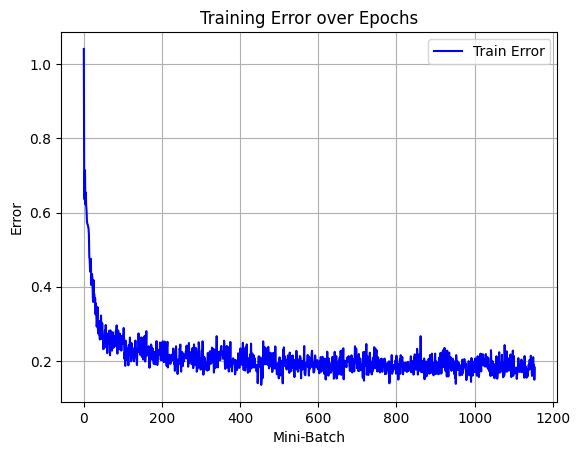

In [ ]:

# # model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = ModelSAGESample(in_feats, h_feats, out_feats)
pred = MLPPredictor(8,3)

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.05)

# ----------- 4. training -------------------------------- #
acc_val = []
acc_train = []

train_error = []
train_error_per_epoch = []
val_error_per_epoch = []
train_edges_id = []

# Inicializar listas para guardar logits y labels del entrenamiento
all_logits_train = []
all_labels_train = []

# Inicializar listas para guardar logits y labels de la validacion
all_logits_val = []
all_labels_val = []
# Almacenar la importancia de características por epoch
feature_importances = []
for epoch in range(5):
    model.train()
    val_loss_epoch=0
    num_batches = 0

    with tqdm.tqdm(train_dataloader) as tq:
        for step, (input_nodes, output_graph, mfgs) in enumerate(tq):
    
            mfgs = [graph for graph in mfgs]
            edge_ids = output_graph.edata[dgl.EID]
            inputs = mfgs[0].srcdata['feat']
            # Hacer que los inputs requieran gradiente
            # Embeddings de nodos
            h = model(mfgs, inputs)
            logits =  pred(output_graph, h)
        
            
            
            train_edges_id.append(edge_ids)

            # Usar los IDs de los bordes para obtener las etiquetas reales
            labels_batch_output = gnn.dgl_graph.edata['Relationship'][edge_ids].to(torch.int64)
            
            all_logits_train.append(logits.detach().cpu().numpy())
            all_labels_train.append(labels_batch_output.cpu().numpy())

            # Calculo pérdida --------------------------------------------------------
            train_loss = F.cross_entropy(logits, labels_batch_output)
            train_error.append(train_loss.item())

            val_loss_epoch += train_loss.item()
            num_batches += 1


            # val_loss_epoch += train_loss.item()
            # num_batches += 1
            
            # backward
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
    train_error_per_epoch.append(val_loss_epoch / num_batches)


    # Validación
    model.eval()
    val_loss_epoch = 0
    num_batches = 0
    with torch.no_grad():
        with tqdm.tqdm(test_dataloader) as tq:
            for step, (input_nodes, output_graph, mfgs) in enumerate(tq):
                mfgs = [graph for graph in mfgs]
                edge_ids = output_graph.edata[dgl.EID]
                inputs = mfgs[0].srcdata['feat']
                
                
                # Forward para validación
                h_val = model(mfgs, inputs)
                logits_val = pred(output_graph, h_val)

                # Guardar logits de validacion
                all_logits_val.append(logits_val.detach().cpu().numpy())

                # Obtener las etiuetas reales
                labels_batch_output_val = gnn.dgl_graph.edata['Relationship'][edge_ids].to(torch.int64)
                all_labels_val.append(labels_batch_output_val.cpu().numpy())
            
                # Calcular pérdida de validación
                val_loss_batch = F.cross_entropy(logits_val, labels_batch_output_val)
                val_loss_epoch += val_loss_batch.item()
                num_batches += 1
            # Almacenar el promedio de la pérdida de validación por epoch
    val_error_per_epoch.append(val_loss_epoch / num_batches)
    if epoch % 1 == 0:
        print('In epoch {}, train loss: {},'.format( epoch,train_loss))



# Crear gráfico del error de entrenamiento
plt.figure()  # Crear una nueva figura
plt.plot([i for i in range(len(train_error))],train_error, label='Train Error', color='blue')  # Error de entrenamiento en azul
plt.xlabel('Mini-Batch')
plt.ylabel('Error')
plt.title('Training Error over Epochs')
plt.legend()
plt.grid(True)
plt.show()  # Mostrar el gráfico de error de entrenamiento



In [ ]:
# Crear gráfico combinado de error de entrenamiento y validación
plt.figure()  # Crear una nueva figura
plt.plot(train_error_per_epoch, label='Train Error', color='blue')  # Error de entrenamiento en azul
plt.plot(val_error_per_epoch, label='Validation Error', color='orange')  # Error de validación en naranja
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Training and Validation Error over Epochs')
plt.legend()
plt.grid(True)
plt.show()  

NameError: name 'plt' is not defined